In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from helpers.makemore_helpers import make_char2idx_map, build_dataset

words = open(r'data\names.txt','r').read().splitlines()
char2idx = make_char2idx_map(words)
idx2char = {v: k for k, v in char2idx.items()}

block_size = 3

In [2]:
train_count = int(len(words) * 0.8)
n_1 = int(len(words) * 0.9)

x_train, y_train = build_dataset(words[:train_count], block_size, char2idx)
x_val, y_val = build_dataset(words[train_count:n_1], block_size, char2idx)
x_test, y_test = build_dataset(words[n_1:], block_size, char2idx)

total_train = len(x_train)
total_val = len(x_val)
total_test = len(x_test)

print(f"Sizes:", total_train, total_val, total_test)
print("Shapes:", x_train.shape, y_train.shape)

Sizes: 182778 22633 22735
Shapes: torch.Size([182778, 3]) torch.Size([182778])


In [3]:
# How to initialize the weights intelligently, so that we have small loss at the beginning?

# For our example, each letter should equally likely at the beginning ( uniform distribution)
# But initializing the weights randomly would cause the network to be confidently wrong at the beginning
# The ideal loss at the beginning should be:
print("Ideal loss in the beginning:",-torch.tensor(1/27).log())


# Example: We want logits to be ~0.0
# logits = torch.tensor([0.0,0.0,0.0,0.0])
logits = torch.randn(4) * 10
probs = F.softmax(logits, dim=0)
loss_for_3nd_idx = -probs[2].log().mean()
logits, probs, loss_for_3nd_idx


Ideal loss in the beginning: tensor(3.2958)


(tensor([ 11.2061, -15.8917,  15.0684, -20.6107]),
 tensor([2.0587e-02, 3.5088e-14, 9.7941e-01, 3.1313e-16]),
 tensor(0.0208))

In [55]:
# Set up parameters
rand_gen = torch.Generator().manual_seed(42)
embedding_size = 10
n_hidden = 200
vocab_size = len(char2idx)

embedding_matrix = torch.randn((vocab_size, 10), generator=rand_gen)
# Because we tanh to remain in the active region
W1 = torch.randn((embedding_size * block_size, n_hidden), generator=rand_gen) *  ( (5/3) / (embedding_size * block_size)**0.5) # this is kaiming initialization
# b1 = torch.randn(n_hidden, generator=rand_gen) * 0.001 # Because we tanh to remain in the active region
W2 = torch.randn((n_hidden, vocab_size), generator=rand_gen) * 0.01 # Because we want smaller logits
b2 = torch.randn(vocab_size, generator=rand_gen) * 0 # Because we want smaller logits

batch_norm_gain = torch.ones((1,n_hidden))
batch_norm_bias = torch.zeros((1,n_hidden))

mean_running = torch.zeros((1,n_hidden))
std_running = torch.ones((1,n_hidden))

params = [embedding_matrix, W1, W2, b2, batch_norm_gain, batch_norm_bias]
for p in params:
    p.requires_grad = True

tensor(0.0042) tensor(0.9913)
tensor(-0.0052) tensor(3.1419)


tensor(0.1997)

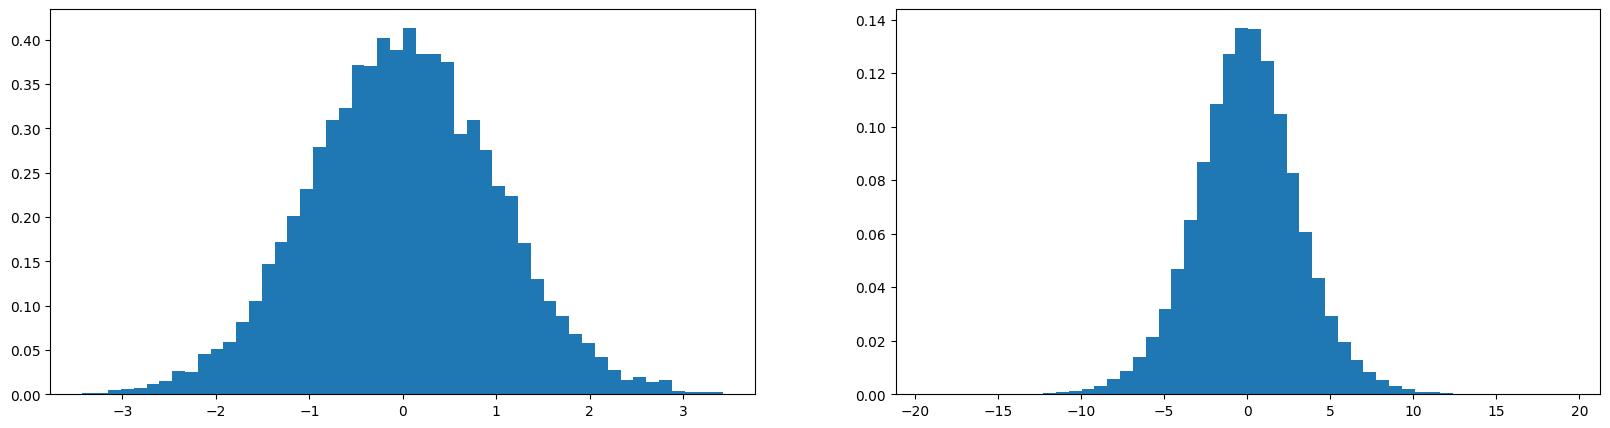

In [5]:
x = torch.randn(1000,10) # random gaussian data
w = torch.randn(10,200) # random gaussian data

y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std()) # we want std of y to be 1

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), bins=50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), bins=50, density=True)

# For gausian dist, whatever number your multiply it by becomes the std
# For example:
(torch.randn(10000) * 0.2).std()

In [56]:
total_steps = 200_000
batch_size = 64
losses = []

for i in range(total_steps):
    # create mini-batch
    indices = torch.randint(0, total_train, (batch_size,))
    xs, ys = x_train[indices], y_train[indices]

    embedding = embedding_matrix[xs]

    # Linear layer
    pre_activation_1 = embedding.view(-1,embedding_size * block_size) @ W1 #+ b1

    # Batch normalization
    mean = pre_activation_1.mean(dim=0, keepdim=True)
    std = pre_activation_1.std(dim=0, keepdim=True)
    pre_activation_1 = (pre_activation_1 - mean) / std
    pre_activation_1 = pre_activation_1 * batch_norm_gain + batch_norm_bias

    # Activation
    activation_1 = torch.tanh(pre_activation_1)
    logits = activation_1 @ W2 + b2

    # Loss
    loss = F.cross_entropy(logits, ys)


    with torch.no_grad():
        mean_running = mean_running * 0.99 + mean * 0.01
        std_running = std_running * 0.99 + std * 0.01

    # Backprop
    for p in params:
        p.grad = None

    loss.backward(retain_graph=True)

    learning_rate = 0.1 if i < 100_000 else 0.01
    for p in params:
        p.data -= learning_rate * p.grad

    losses.append(loss.item())
    if i % 10000 == 0:
        print(f"Step {i}, loss {loss.item():.4f}")

    # break
print("Final loss:", loss.item())



Step 0, loss 3.3205
Step 10000, loss 2.0718
Step 20000, loss 2.3563
Step 30000, loss 1.7852
Step 40000, loss 1.9793
Step 50000, loss 1.9948
Step 60000, loss 2.0577
Step 70000, loss 2.3441
Step 80000, loss 1.9885
Step 90000, loss 2.1005
Step 100000, loss 2.2134
Step 110000, loss 2.0647
Step 120000, loss 1.6815
Step 130000, loss 2.0458
Step 140000, loss 1.7594
Step 150000, loss 1.7827
Step 160000, loss 2.0774
Step 170000, loss 1.9061
Step 180000, loss 2.1826
Step 190000, loss 2.0523
Final loss: 2.0332083702087402


(array([1392.,  570.,  431.,  359.,  299.,  284.,  242.,  230.,  186.,
         191.,  165.,  187.,  187.,  158.,  161.,  130.,  145.,  157.,
         146.,  138.,  155.,  155.,  125.,  117.,  136.,  138.,  148.,
         150.,  107.,  128.,  159.,  130.,  158.,  145.,  164.,  152.,
         174.,  154.,  160.,  150.,  227.,  205.,  217.,  211.,  248.,
         311.,  357.,  407.,  559., 1395.]),
 array([-9.99998271e-01, -9.59998463e-01, -9.19998655e-01, -8.79998847e-01,
        -8.39999039e-01, -7.99999231e-01, -7.59999423e-01, -7.19999615e-01,
        -6.79999807e-01, -6.39999999e-01, -6.00000191e-01, -5.60000383e-01,
        -5.20000575e-01, -4.80000767e-01, -4.40000958e-01, -4.00001150e-01,
        -3.60001342e-01, -3.20001534e-01, -2.80001726e-01, -2.40001918e-01,
        -2.00002110e-01, -1.60002302e-01, -1.20002494e-01, -8.00026858e-02,
        -4.00028777e-02, -3.06963921e-06,  3.99967384e-02,  7.99965465e-02,
         1.19996355e-01,  1.59996163e-01,  1.99995971e-01,  2.399957

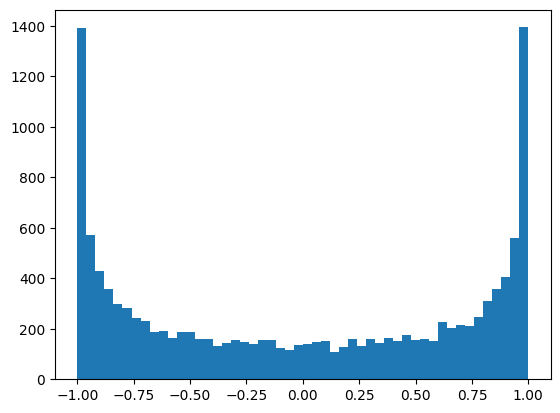

In [24]:
plt.hist(activation_1.view(-1).tolist(), bins=50)

(array([  1.,   0.,   0.,   1.,   5.,   6.,  11.,  17.,  16.,  17.,  26.,
         45.,  75.,  99., 114., 151., 205., 271., 305., 397., 507., 614.,
        694., 734., 856., 931., 859., 882., 794., 772., 641., 578., 485.,
        356., 346., 259., 207., 134., 114.,  87.,  58.,  42.,  24.,  20.,
         12.,  14.,  10.,   1.,   5.,   2.]),
 array([-6.98163509, -6.71753589, -6.45343668, -6.18933747, -5.92523827,
        -5.66113906, -5.39703985, -5.13294065, -4.86884144, -4.60474223,
        -4.34064302, -4.07654382, -3.81244461, -3.5483454 , -3.2842462 ,
        -3.02014699, -2.75604778, -2.49194858, -2.22784937, -1.96375016,
        -1.69965096, -1.43555175, -1.17145254, -0.90735333, -0.64325413,
        -0.37915492, -0.11505571,  0.14904349,  0.4131427 ,  0.67724191,
         0.94134111,  1.20544032,  1.46953953,  1.73363873,  1.99773794,
         2.26183715,  2.52593636,  2.79003556,  3.05413477,  3.31823398,
         3.58233318,  3.84643239,  4.1105316 ,  4.3746308 ,  4.63873001,
 

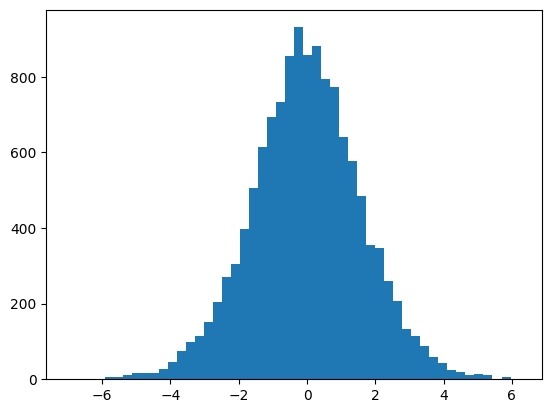

In [25]:
plt.hist(pre_activation_1.view(-1).tolist(), bins=50)

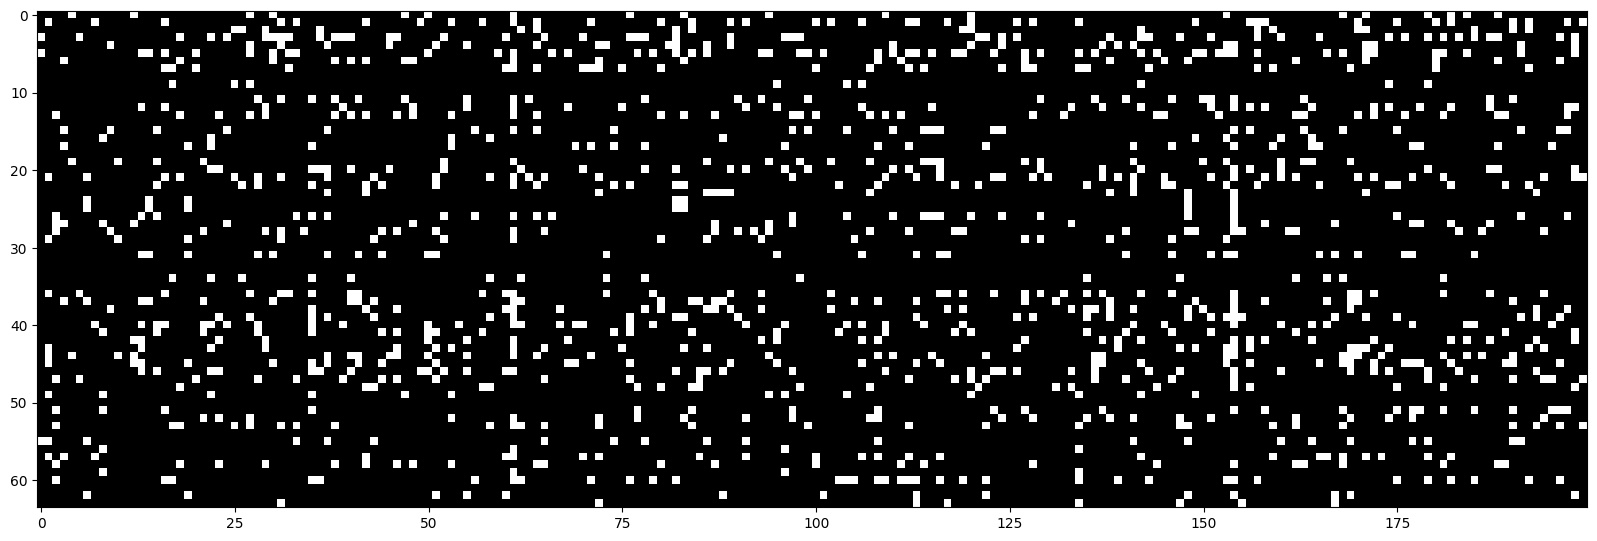

In [57]:

# If any coloum is fully white, that would mean that that particular neuron is not activated for any of the inputs, and hence it cannot learn

plt.figure(figsize=(20,10))
plt.imshow(activation_1.abs() > 0.99, cmap='gray', interpolation='nearest')

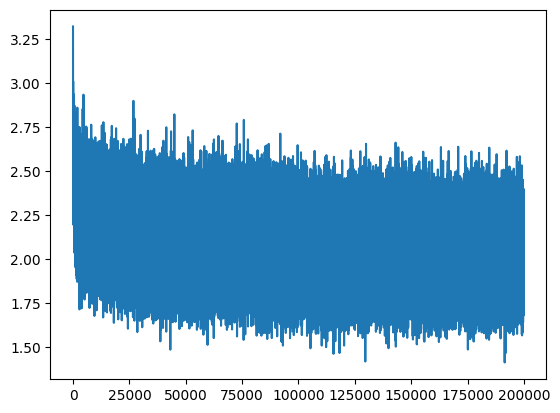

In [58]:
plt.plot(losses)

In [49]:

# calculate mean and std for pre-activations over the whole dataset
# this can also be calculated in a running manner

with torch.no_grad():
    embedding = embedding_matrix[x_train]
    pre_activation_1 = embedding.view(-1,embedding_size * block_size) @ W1 + b1

    # Batch normalization
    mean_wholeset = pre_activation_1.mean(dim=0, keepdim=True)
    std_wholeset = pre_activation_1.std(dim=0, keepdim=True)

print(mean_wholeset, std_wholeset)
print(mean_running, std_running)


tensor([[ 2.2565,  0.7771, -0.4146,  0.4131, -0.4423, -0.9669, -0.3833, -0.0513,
         -0.0751,  0.3580,  0.2852, -0.3416, -1.1099,  0.4672, -0.0890, -0.9616,
         -0.4494,  0.0831, -0.4804, -0.6617, -0.7680,  0.9445, -1.2265,  0.0197,
         -1.7021, -0.7052,  1.2704,  0.4390,  1.5423, -1.6024, -1.2217,  0.3014,
          0.1730,  0.6822,  0.2122,  1.9862, -0.2264, -1.1627,  0.5550,  1.2731,
          1.3079, -1.2902, -0.9899, -0.0665, -1.1983,  0.7909,  0.6115,  1.2298,
          0.6580, -0.8370,  1.5325,  0.2126, -0.4384, -0.6037, -0.1098,  0.6227,
          0.7353,  0.6411, -0.1555,  0.4638, -0.3216,  2.0078,  0.5449,  0.2592,
         -0.2699,  0.5424,  1.1868,  0.8343,  0.9411,  0.3300, -1.1437, -0.9091,
          0.4455, -1.0066,  1.7415,  0.8675, -2.0987,  0.3345, -0.8343, -1.1341,
          1.3676,  1.1532, -0.4742,  0.6808, -0.0048,  1.1348,  1.1719,  0.3912,
          0.6371,  0.7552, -0.4991,  0.1275,  1.3191,  1.0616, -1.3230, -0.8386,
          0.4412, -0.6173,  

In [59]:
@torch.no_grad()
def eval_loss(set_name: str):
    x, y = {
        "train": (x_train, y_train),
        "val": (x_val, y_val),
        "test": (x_test, y_test),
    }[set_name]

    embedding = embedding_matrix[x]
    pre_activation_1 = embedding.view(-1,embedding_size*block_size) @ W1 + b1

    # Batch normalization
    pre_activation_1 = (pre_activation_1 - mean_running) / std_running
    pre_activation_1 = pre_activation_1 * batch_norm_gain + batch_norm_bias
    

    activation_1 = torch.tanh(pre_activation_1)
    logits = activation_1 @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f"{set_name} loss: {loss.item():.4f}")

eval_loss("train")
eval_loss("val")
    

train loss: 1.9985
val loss: 2.3070


In [61]:
rand_gen = torch.Generator().manual_seed(42)

for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        emb = embedding_matrix[
            torch.tensor([context])
        ]

        pre_act_1 = emb.view(1,-1) @ W1 + b1

        # Batch normalization
        pre_act_1 = (pre_act_1 - mean_running) / std_running
        pre_act_1 = batch_norm_gain * pre_act_1 + batch_norm_bias



        act_1 = torch.tanh(pre_act_1)
        logits = act_1 @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1,generator=rand_gen).item()
        context = context[1:] + [ix]
        
        if ix == 0:
            break

        out.append(ix)

    print(''.join([idx2char[i] for i in out]))

anuelen
tia
marian
dan
shan
silayley
kemarce
mar
epiacelle
jamee
kend
josey
gur
lak
mikolynn
acvisia
ace
lavitta
cli
jaymar
